# NOTES

### Task 1
Classify whether a loan will go into default or not

Should use 10-fold validation, and 15-20% of the data as test

Will use Neural Network, Ada Boosting, and SVM classifications

Need to include Visualizations - confusion matrices, bar chart of weighted factors, etc.

### Task 2
Use time series regression to predict monetary need for company in the next year

Use all but the final year of data as training to predict the final year as training model

Will use couple different types of ARMA, and maybe Vector Auto Regression (if in SAS)

Again need visualizations - confusion matrices, bar chart of weighted factors, etc.

#### Final Thoughts
Check the time to run each calculation via %timeit

Make sure to try various variables in each prediction model to get the best resuslts

See if there is a way to do stepwise or forward/backward search of features

To convert infinity to NAN, need to convert column to float and then can convert back as needed

# Mini Lab

## Brett Hallum, Mridul Jain, and Solomon Ndungu

We start this lab by filtering out our unwanted data. A lot of this information was removed in Lab 1 as it did not make sense for us to use it due to missing values, single values for whole set, and a minimal distribution of values. On top of this removal, we do some imputation to fill in minor missing data values. Finally, we do some nominal classification on some of our data to order it for better use.

We do create two additional data frames, loan_df_finished and loan_df_unfinished, at this point as well. Their purpose and usage will be discussed shortly.

In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'mths_since_last_major_derog', 'desc', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

for col in ['total_pymnt']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp 
   

tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']
    
loan_df.head()

,funded_amnt,term,installment,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,total_acc,...,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding
0,5000.0,36,162.87,24000.0,Dec-2011,27.65,0.0,1.0,3.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500.0,60,59.83,30000.0,Dec-2011,1.00,0.0,5.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2400.0,36,84.33,12252.0,Dec-2011,8.72,0.0,2.0,2.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10000.0,36,339.31,49200.0,Dec-2011,20.00,0.0,1.0,10.0,37.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3000.0,60,67.79,80000.0,Dec-2011,17.94,0.0,0.0,15.0,38.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
loan_df = loan_df.dropna()
print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869720 entries, 0 to 887378
Data columns (total 56 columns):
funded_amnt                        869720 non-null float64
term                               869720 non-null int64
installment                        869720 non-null float64
annual_inc                         869720 non-null float64
issue_d                            869720 non-null object
dti                                869720 non-null float64
delinq_2yrs                        869720 non-null float64
inq_last_6mths                     869720 non-null float64
open_acc                           869720 non-null float64
total_acc                          869720 non-null float64
total_pymnt                        869720 non-null float64
last_pymnt_d                       869720 non-null object
acc_now_delinq                     869720 non-null float64
grade_A                            869720 non-null float64
grade_B                            869720 non-null float64
grade_C 

In [4]:
from datetime import datetime
loan_df['duration_paid'] =  (pd.to_datetime(loan_df['last_pymnt_d']) - pd.to_datetime(loan_df['issue_d']))

In [5]:
loan_df['Count_Days'] =  loan_df['duration_paid'].dt.days
loan_df['Payment_rate'] =  loan_df['total_pymnt'] / (loan_df['Count_Days']+1)*30
loan_df['Payment_ratio'] = loan_df['Payment_rate']/ loan_df['installment']

In [6]:
loan_df = loan_df.dropna()

In [7]:
if "issue_d" in loan_df:
    del loan_df["issue_d"]
if "last_pymnt_d" in loan_df:
    del loan_df["last_pymnt_d"]
if "total_pymnt" in loan_df:
    del loan_df["total_pymnt"]
if "duration_paid" in loan_df:
    del loan_df['duration_paid']

In [8]:
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans

#loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

In [9]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869720 entries, 0 to 887378
Data columns (total 55 columns):
funded_amnt                        869720 non-null float64
term                               869720 non-null int64
installment                        869720 non-null float64
annual_inc                         869720 non-null float64
dti                                869720 non-null float64
delinq_2yrs                        869720 non-null float64
inq_last_6mths                     869720 non-null float64
open_acc                           869720 non-null float64
total_acc                          869720 non-null float64
acc_now_delinq                     869720 non-null float64
grade_A                            869720 non-null float64
grade_B                            869720 non-null float64
grade_C                            869720 non-null float64
grade_D                            869720 non-null float64
grade_E                            869720 non-null float64
grade_

In [10]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from matplotlib import pyplot as plt


# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

# Shuffle split our data into an 80/20 breakdown. The 80 will be used for training and the 20 for testing
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(869720, n_iter=5, test_size=0.2, random_state=None)


### Logistic Regression

We will begin by conducting a logistic regression on the full data set. We will look at the accuracy of the classification to see how accurate the regression model is and the confusion matrix to see if there are any oddities in the breakdown.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Fit and test the regression model for each shuffled instance
for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.930408637263
confusion matrix
[[     0  12105]
 [     0 161839]]
====Iteration 1  ====
accuracy 0.930080945592
confusion matrix
[[     0  12162]
 [     0 161782]]
====Iteration 2  ====
accuracy 0.93056960861
confusion matrix
[[     0  12077]
 [     0 161867]]
====Iteration 3  ====
accuracy 0.930149933312
confusion matrix
[[     0  12150]
 [     0 161794]]
====Iteration 4  ====
accuracy 0.930563859633
confusion matrix
[[     0  12078]
 [     0 161866]]


In [12]:
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]

In [13]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

In [14]:
loan_df_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270178 entries, 0 to 887371
Data columns (total 54 columns):
funded_amnt                        270178 non-null float64
term                               270178 non-null int64
installment                        270178 non-null float64
annual_inc                         270178 non-null float64
dti                                270178 non-null float64
delinq_2yrs                        270178 non-null float64
inq_last_6mths                     270178 non-null float64
open_acc                           270178 non-null float64
total_acc                          270178 non-null float64
acc_now_delinq                     270178 non-null float64
grade_A                            270178 non-null float64
grade_B                            270178 non-null float64
grade_C                            270178 non-null float64
grade_D                            270178 non-null float64
grade_E                            270178 non-null float64
grade_

In [15]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=10, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "==== Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

==== Iteration 0  ====
accuracy 0.957861425716
confusion matrix
[[10191  1884]
 [  393 41568]]
==== Iteration 1  ====
accuracy 0.958509142053
confusion matrix
[[10078  1898]
 [  344 41716]]
==== Iteration 2  ====
accuracy 0.957380265009
confusion matrix
[[10047  2018]
 [  285 41686]]
==== Iteration 3  ====
accuracy 0.956788067214
confusion matrix
[[ 9982  1979]
 [  356 41719]]
==== Iteration 4  ====
accuracy 0.958009475165
confusion matrix
[[10227  1898]
 [  371 41540]]


The results of this classification not only have a higher accuracy than the original, full data set, right around 97.9% on average rather than 93.1%, but it also has better looking confusion mattrices. There are data points that are classified correctly. Although there are still a large number of bad loans being incorrectly identified as good, it is much better distributed than the original set.

We follow up this analysis by looking at the weight of each factor used. This will help us figure out if there are certain features that are more influential than others to help with the classification of each point.

In [16]:
# Non-normalized weights
# Iterate over the coefficients to get the weight for each variable
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.00014595994168
term has weight of -0.104539509989
installment has weight of -0.0104338306754
annual_inc has weight of 5.18075566237e-06
dti has weight of -0.0238444220104
delinq_2yrs has weight of -0.00171370436506
inq_last_6mths has weight of -0.00629719962202
open_acc has weight of -0.00871329916341
total_acc has weight of 0.016251649981
acc_now_delinq has weight of -3.53703591993e-05
grade_A has weight of 0.00252899732031
grade_B has weight of 0.00101200088805
grade_C has weight of -0.00127374756417
grade_D has weight of -0.00227084117453
grade_E has weight of -0.00122771766023
grade_F has weight of -0.00054749446191
grade_G has weight of -0.000172810850784
Employ_1 year has weight of -0.000185483272426
Employ_10+ years has weight of 7.44778546524e-05
Employ_2 years has weight of -0.000199388458871
Employ_3 years has weight of -9.64506906998e-05
Employ_4 years has weight of -8.74674108548e-05
Employ_5 years has weight of -0.000114043123368
Employ_6 years

We want to normalize the weights for each variable so that a much larger valued variable, such as the funded amount, is weighted the same as a small valued variable such as one that is binary or nominal.

Employ_7 years has weight of -0.00207545983768
Employ_6 years has weight of 0.00335649204723
Employ_10+ years has weight of -0.00394678448088
Employ_< 1 year has weight of 0.00409695651846
Employ_5 years has weight of 0.00596613463871
Employ_9 years has weight of -0.00608152302807
Employ_8 years has weight of -0.00650083994892
Loan_Purpose_major_purchase has weight of 0.00761846432269
Loan_Purpose_car has weight of -0.0077708893308
Home_NONE has weight of -0.00793534356547
Employ_1 year has weight of 0.00805505335547
Home_OWN has weight of -0.00884032270306
Home_OTHER has weight of -0.0102603067283
Loan_Purpose_renewable_energy has weight of -0.0111960888794
Loan_Purpose_house has weight of -0.0111964498503
acc_now_delinq has weight of -0.0116961097223
Employ_2 years has weight of 0.0142799791353
Employ_4 years has weight of 0.0160870665294
Loan_Purpose_wedding has weight of 0.0162375787746
Loan_Purpose_medical has weight of -0.0184813958379
Loan_Purpose_vacation has weight of -0.01892

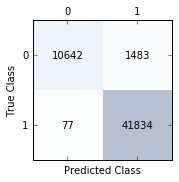

In [17]:
warnings.simplefilter("ignore")
%matplotlib inline

# Normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)


# Sort the attributes on size and print them out in order of weight
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out
    
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

print 'accuracy:', acc

After scaling the data, we still get a similar accuracy to before and our confusion matrix has remained proportional. The scaled view of the variables provides a better way to compare each of the variables to one another and see which have a significant impact. In the graph below, it is even easier to note which variables have the most impact. The funded amount and total payment variables have a significant impact over any of the rest of the variables. Other notable variables that are valued slightly higher than the other factors are the Interst Rate Range, annual income and the number of total accounts someone has.

These values make a lot of sense as to why they are the most important. The total payment should definitely be a factor that plays into determining if a loan is good or bad. If the loan is in good standing, the full principle amount will be paid off. This will relate positively because as you pay more back to the bank, you will become closer to finishing the loan. Alternatively, the less money you have paid the more likely you are to default on the loan. Funded amount and interest rate range are also valuable. Banks probably use these in relation to one another to determine who will default and give certain rates for ceratin funded amounts. They are negatively weighted in this case which means the higher the interest rate and the higher the funded amount, the more likely someone is to default. As a loan increases in value and interest rate, it gets more difficult to pay off the loan and so someone is more likely to go into default and end up with a "bad" loan.

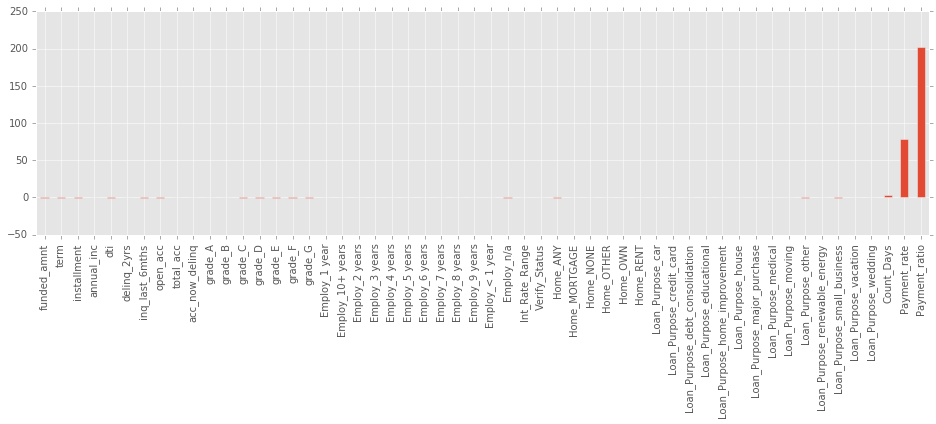

In [18]:
# now let's make a pandas Series with the names and values, and plot them

%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(16, 4))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

### Support Vector Machines

We continue our trials by observing the Support Vector Machines (SVM) to see if this method of classification can classify our data set better than logistic regression. We will start by observing the SVM of our original data set. Although it will most likely turn out the same way, not giving very good data, the SVM may reveal new splits in the decision. We will follow that up with looking at the SVM of the reduced data set that contains the completed loans. We can compare the accuracy of the SVM with the above logistic regression to determine if one classifies this data better than the other.

Note: We use the SGDClassifier due to the size of our data set. Both sets are large and would take too long to train with a normal SVM in a time that is reasonable.

SVM: 0.930201674102
Confusion Matrix:
[[     0  12141]
 [     0 161803]]
Coefficients [[  6.71098770e-04  -8.10068282e-03  -1.86578947e-03   8.71528680e-03
   -8.77815997e-04   5.87110912e-04  -1.65963551e-02   3.79292339e-03
    4.09436391e-03  -1.34211645e-04   2.03220666e-02   1.21112980e-02
   -1.86550243e-03  -1.53683541e-02  -1.65641423e-02  -1.15531218e-02
   -3.79056585e-03  -5.53142390e-04   4.48507280e-03   7.70575287e-05
    3.06082659e-04  -3.68552072e-04  -1.46259417e-03  -2.45179362e-03
   -1.47070636e-03   5.71783882e-04  -4.07616098e-05  -1.64482356e-03
   -2.08862492e-03  -3.76980791e-02  -5.18435898e-03   1.14868522e-04
    7.13942580e-03  -3.16122314e-04  -1.35175667e-03   1.18317482e-03
   -7.95581433e-03   6.01542596e-04   8.55058968e-03  -4.03838508e-03
   -2.10276867e-03   1.45009895e-03  -1.37203110e-03   2.36089202e-04
   -1.56827405e-03  -2.22677028e-03  -3.72833004e-03  -1.16818018e-03
   -5.89707059e-03  -3.42763725e-04  -2.13410842e-03   1.30808319e-04
    

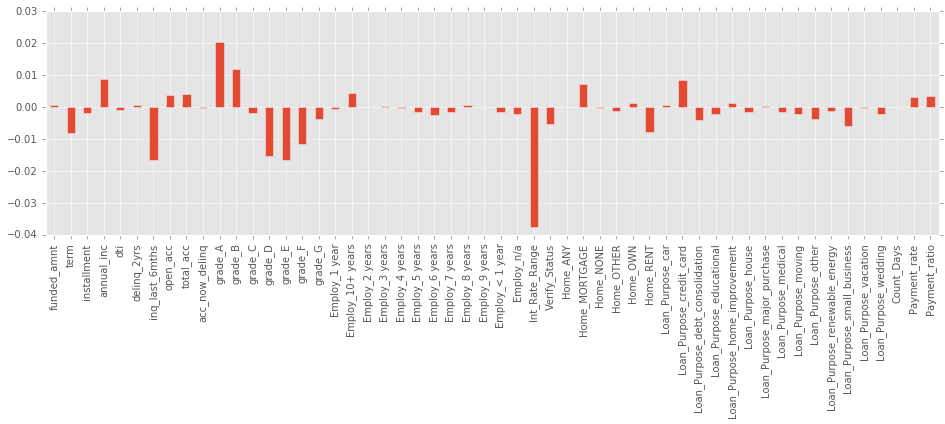

In [19]:
# SVM of full data set
warnings.simplefilter("ignore")

# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

# Get SVM classifier
regularize_const = 1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

# Fit our data (after it is scaled) to an SVM classification
scl = StandardScaler()
for train_idx, test_idx in cv_obj:
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(16,4))

The accuracy of the full data set remained very similar. It stayed at around 93% accuracy, but still has the same style of confusion matrix from the logistic regression with bad loans being classified as good ones. We now look at the SVM of the reduced data to see how it performs.

SVM: 0.819250129543
Confusion Matrix:
[[ 2369  9604]
 [  163 41900]]
Coefficients [[  2.85079696e-02  -1.57593260e-01  -1.69066076e-01   3.17169428e-02
   -5.26311129e-02  -2.51948291e-05  -2.28504866e-02  -1.05757274e-02
    6.67655917e-02  -6.40699830e-02   3.00621026e-02   5.55765421e-02
    2.92632032e-02   1.79769820e-04  -1.15732370e-01  -5.91013380e-02
   -7.35379580e-02   5.01711308e-03  -1.14643147e-02   5.41447306e-03
    2.07012222e-03   2.54646663e-02   1.42072608e-02   3.86647486e-02
   -1.08216190e-02  -8.94476211e-03  -1.76379941e-02   7.33657274e-03
   -5.74009758e-02   3.08213723e-02   1.78518347e-02   3.36308545e-04
    1.82151916e-02   2.17973522e-03   4.16137045e-03  -1.36839049e-02
   -1.08910979e-02   1.09579146e-02   1.89190161e-02   1.95793810e-02
    6.05808208e-03  -1.59380079e-02   1.27013563e-02   7.00090607e-03
   -9.45918722e-03  -6.69088507e-03  -2.14291554e-02   4.94516613e-03
   -7.97953089e-02  -1.14801882e-02   1.35702294e-02   5.22545268e-01
    5.66

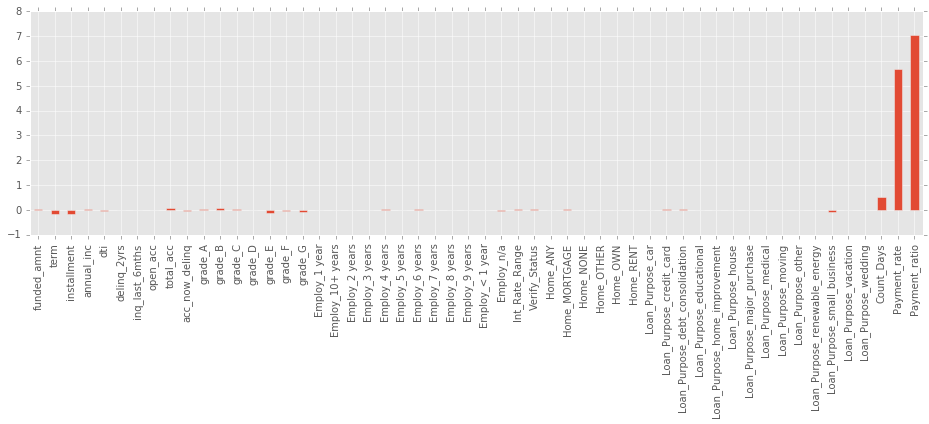

In [20]:
# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

regularize_const = 0.001
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(16,4))

The SVM for the reduced data, which includes just completed loans, has a much lower accuracy than the logistic regression classification of the same data. The accuracy dropped from just below 98.0% to around 86.8%. This is a significant difference. It is possible that part of this is due to SGDClassifier taking the Stochastic Gradient instead of the full gradient of the SVM. Although the SGD runs faster than the linear regression model we used (LinearRegression()), it does not have the accuracy that we would expect or want in this situation, especially when the original data stayed around the same accuracy between the two different classifications.

It is interesting to note that the classes that the SVM pulls out are almost identical to the ones the logistic regression uses. Funded amount and total payment are still at the top of the list with Interest Rate Range being a distant fourth, but still near the top. Surprisingly, it has added importance on the 'Term' variable that the logistic regression did not pull out.

### AdaBoosting with Decision Trees

AdaBoost: 0.992949145014


<function matplotlib.pyplot.show>

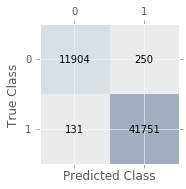

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME", n_estimators=50)

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    clf_ada.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = clf_ada.predict(scl.transform(updated_X[test_idx]))
        
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'AdaBoost:', acc

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

### AdaBoosting with weak learners like Random Forests

AdaBoost: 0.985694722037


<function matplotlib.pyplot.show>

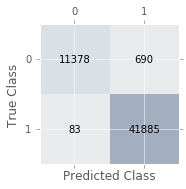

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf_ada = AdaBoostClassifier(RandomForestClassifier(n_estimators=5, random_state=0), algorithm="SAMME", n_estimators=50)

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    clf_ada.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = clf_ada.predict(scl.transform(updated_X[test_idx]))
        
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'AdaBoost:', acc

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show

### Additional Analysis: Are there better parameter or variable choices?

As suggested by the Batch SVM previously, it looks like there might be better parameter set that can help us generage the best Bias-variance trade-off. In this section, we want to see if we can improve the overall accuracy of our model by adjusting the parameters we pass into our Logistic Regression and SVM models and by reducing the number of variables we look at with our model. Either of these changes could lead to better performance in both accuracy and the confusion mattrices.

Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters that lead to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance
on unseen data. There are various parameters for finding a good bias-variance tradeoff and to tune the complexity of the model via regularization. 

Cost Function 'C' : A large C gives you low bias and high variance. Low bias because you penalize the cost of missclasification a lot. A small C gives you higher bias and lower variance. A lower C means higher regularization. A lower C thus prevents overfitting.

L1/L2 Regularization : L2 regularization (sometimes also called L2 shrinkage or weight decay) or L1 regularization where penalty is the sum of the absolute weight coefficients while in L2 that term is quadratic)

Below we will try to change the model parameters and try find the optimal values for these parameters.

Please note that both SVC and LinearSVC have the regularization hyperparameter C, but the SGDClassifier has the regularization hyperparameter alpha. Where C = n_samples / alpha

### Analysis 1: Changing Model Parameters

In [23]:
# Changing SVM Model Parameters - can alter penalty, L1 ratio and alpha

for val in range(6):
    print "======= L1 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=1, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L1 Penalty with l1_ratio =", (val/4.0), "========"
    regularize_const = 0.0001
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=val/4, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L1')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf
    
for val in range(6):
    print "======= L2 Penalty with alpha =", 10**(-val), "========"
    regularize_const = 10**(-val)
    iterations = 6
    svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='hinge', n_iter=iterations, n_jobs=-1, penalty='L2')

    scl = StandardScaler()
    for train_idx, test_idx in updated_cv_obj:
        svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
        yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))

        conf = mt.confusion_matrix(updated_y[test_idx],yhat)
        acc = mt.accuracy_score(updated_y[test_idx],yhat)

    print 'SVM:', acc
    print 'Confusion Matrix:\n', conf

======= L1 Penalty with alpha = 1 ========
SVM: 0.77539048042
Confusion Matrix:
[[    0 12137]
 [    0 41899]]
======= L1 Penalty with alpha = 0.1 ========
SVM: 0.776870974906
Confusion Matrix:
[[    0 12057]
 [    0 41979]]
======= L1 Penalty with alpha = 0.01 ========
SVM: 0.906691835073
Confusion Matrix:
[[ 7169  4944]
 [   98 41825]]
======= L1 Penalty with alpha = 0.001 ========
SVM: 0.937911762529
Confusion Matrix:
[[ 8788  3305]
 [   50 41893]]
======= L1 Penalty with alpha = 0.0001 ========
SVM: 0.983418461766
Confusion Matrix:
[[11295   804]
 [   92 41845]]
======= L1 Penalty with alpha = 1e-05 ========
SVM: 0.982992819602
Confusion Matrix:
[[11381   645]
 [  274 41736]]
======= L1 Penalty with l1_ratio = 0.0 ========
SVM: 0.979088015397
Confusion Matrix:
[[11126  1029]
 [  101 41780]]
======= L1 Penalty with l1_ratio = 0.25 ========
SVM: 0.980253904804
Confusion Matrix:
[[11060   974]
 [   93 41909]]
======= L1 Penalty with l1_ratio = 0.5 ========
SVM: 0.981327263306
Confusio

The unscaled data of this significantly reduced data set has a marginally better fit than the original reduced data set. If you compare the 98.1% average of the newly reduced data set to the 97.9% of the base reduced data, you get a slightly better performance by taking out some of the less important, according to the logistic regression, variables. The scaled data comes in at a similar accuracy rating of the original sample at 97.9% so there really is not a huge change here. Even looking at the weights of each, the funded amount and total payment factors still far outweigh the others.

### Analysis 2: Reduced Number of Factors
In this section, we will use the logistic regression classification, which seemed to perform better for our reduced data set, to see if we can increase the accuracy of our model by looking at different variable inputs. The idea is to reduce the number of inputs to try and improve the data. What if we look at our major regression factors and limit our dataset to those factors? Do we improve accuracy any by limiting the data given to the classifier?

In [24]:
used_temp_df = pd.DataFrame()
major_factors_df = loan_df_finished

for col in ['funded_amnt', 'Int_Rate_Range' , 'Payment_rate' , 'Payment_ratio', 'annual_inc', 'Verify_Status']:
    if col in major_factors_df:
        used_temp_df[col] = major_factors_df[col]
        
updated_X = used_temp_df.values

updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

====Iteration 0  ====
accuracy 0.829909689836
confusion matrix
[[ 6040  6203]
 [ 2988 38805]]
====Iteration 1  ====
accuracy 0.831464209046
confusion matrix
[[ 5949  6140]
 [ 2967 38980]]
====Iteration 2  ====
accuracy 0.831353171959
confusion matrix
[[ 5954  6202]
 [ 2911 38969]]
====Iteration 3  ====
accuracy 0.829687615664
confusion matrix
[[ 5888  6259]
 [ 2944 38945]]
====Iteration 4  ====
accuracy 0.833740469317
confusion matrix
[[ 5980  6064]
 [ 2920 39072]]


accuracy: 0.850081427197
[[ 5775  6269]
 [ 1832 40160]]


<function matplotlib.pyplot.show>

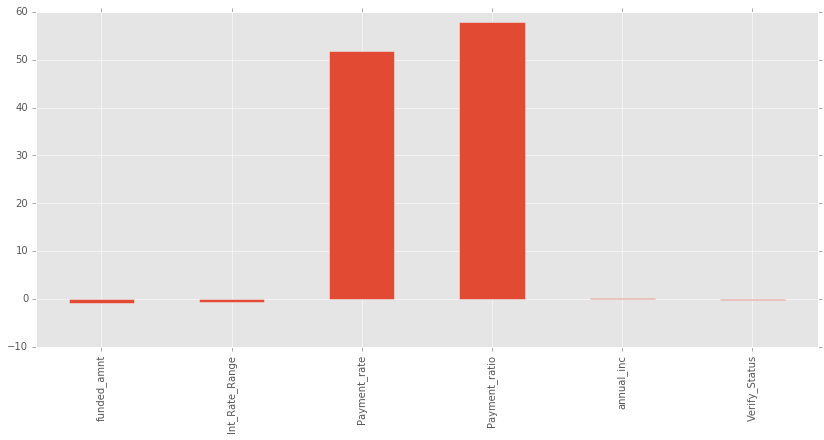

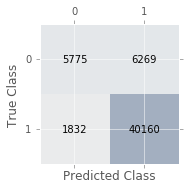

In [25]:
scl = StandardScaler()
scl.fit(updated_X[train_indices])

X_train_scaled = scl.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scl.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
weights = pd.Series(updated_logreg_obj.coef_[0],index=used_temp_df.columns)
weights.plot(kind='bar', figsize=(14,6))

fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha = 0.3)
for i in range (conf.shape[0]):
    for j in range (conf.shape[1]):
        ax.text(x=j, y=i, s=conf[i, j], va = 'center', ha = 'center')
plt.xlabel ('Predicted Class')
plt.ylabel ('True Class')
plt.show